In [14]:
from pyspark import SparkContext
import math
import pandas as pd

## Configuração inicial

In [2]:
sc = SparkContext(appName="Teste")

In [3]:
rdd = sc.sequenceFile("pages/part-00000")

In [4]:
#total de documentos na base
total_docs = rdd.count()

#### Funções de tratamento

In [5]:
#Quantas ocorrencias da palavra em todos documentos
def conta_palavras(item):
    texto = item[1]
    palavras = texto.strip().split()
    return [(palavra.lower(),1) for palavra in palavras]

In [6]:
#Conta quantos docs cada palavra aparece
def conta_docs(item):
    texto = item[1]
    palavras = texto.strip().split()
    return [(palavra.lower(),1) for palavra in set(palavras)]
rdd_docs_word = rdd.flatMap(conta_docs).reduceByKey(lambda x,y: x + y).cache()

In [7]:
#Filtra palavras que aparecem em certa quantidade de docs
doc_freq_min = 10
doc_freq_max = 0.7 * total_docs
def filtra(item):
    contagem = item[1]
    return (contagem < doc_freq_max) and (contagem > doc_freq_min)

#RDD com quantos docs cada palavra aparece considerando intervalo limite de 5 a 0.7*total_documentos
rdd_docs_filtrado = rdd_docs_word.filter(filtra)

#### Análise do vocabulário comum

In [8]:
#Calcula idf de cada palavra filtrada
def computa_idf(item):
    palavra, contagem = item
    idf = math.log10(total_docs / contagem)
    return (palavra, idf)
rdd_idf = rdd_docs_filtrado.map(computa_idf)
rdd_idf.take(10)

[('pons', 3.4117759853793284),
 ('r$', 0.5932673172690647),
 ('//}', 3.3274550996792924),
 ('à', 0.32189609502544525),
 ('e-mail', 0.43047524320596725),
 ('bom', 0.8289013117853762),
 ('joaquim', 1.6987657237630354),
 ('cantores', 2.5086859983873846),
 ('região', 0.881576287176246),
 ('*', 0.864528870032381)]

#### Análise do vocabulário específico

In [9]:
#Filtrar RDDs para selecionar conjuntos com cada palavra definida.
rdd_oreo = rdd.filter(lambda x: "oreo" in x[1]) 
rdd_negresco = rdd.filter(lambda x: "negresco" in x[1]) 

In [10]:
#Cálculo da frequência para os RDDs dos dois conjuntos.
rdd_freq_oreo = rdd_oreo.flatMap(conta_palavras).reduceByKey(lambda x,y: x + y).map(lambda x: (x[0], math.log10(1 + x[1]))).cache()
rdd_freq_negresco = rdd_negresco.flatMap(conta_palavras).reduceByKey(lambda x,y: x + y).map(lambda x: (x[0], math.log10(1 + x[1]))).cache()

In [11]:
#Intersecção dos dois conjuntos de frequência.
rdd_inter = rdd_freq_oreo.intersection(rdd_freq_negresco)

##### Tabela com 100 palavras mais relevantes onde os dois itens aparecem conjuntamente

In [31]:
#Calcula 100 palavras mais relevantes em conjunto às palavras escolhidas
rdd_all = rdd_inter.join(rdd_idf).map(lambda x: (x[0], x[1][0]*x[1][1])).takeOrdered(100, key=lambda x: -x[1])
df = pd.DataFrame(rdd_all, columns = ["palavra", "relevancia"])
df_csv = df.to_csv("rdd_all.csv", index=False)

##### Tabela com 100 palavras mais relevantes sem a presença de "negresco"

In [32]:
#Calcula 100 palavras mais relevantes com apenas do conjunto Oreo
rdd_oreo = rdd_freq_oreo.subtractByKey(rdd_freq_negresco).join(rdd_idf).map(lambda x: (x[0], x[1][0]*x[1][1])).takeOrdered(100, key=lambda x: -x[1])
df_o = pd.DataFrame(rdd_oreo, columns = ["palavra", "relevancia"])
df_o_csv = df_o.to_csv("rdd_oreo.csv", index=False)

##### Tabela com 100 palavras mais relevantes sem a presença de "oreo"

In [33]:
#Calcula 100 palavras mais relevantes com apenas do conjunto Negresco
rdd_negresco = rdd_freq_negresco.subtractByKey(rdd_freq_oreo).join(rdd_idf).map(lambda x: (x[0], x[1][0]*x[1][1])).takeOrdered(100, key=lambda x: -x[1])
df_n = pd.DataFrame(rdd_negresco, columns = ["palavra", "relevancia"])
df_n_csv = df_n.to_csv("rdd_negresco.csv", index=False)

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

dict_freq = {}
for i,row in df.iterrows():
    dict_freq[row["palavra"]] = row["relevancia"]
print(dict_freq)

{'torta': 4.456427225433909, 'pudim': 3.753504688553287, 'bolinho': 3.5787791319740143, 'bacalhau': 3.3509755150270633, 'nhoque': 3.2800527750322774, 'pao': 3.1429306730867483, 'gelado': 3.0815627033019317, 'destinations': 2.971796837656449, 'pavê': 2.953863435523417, 'docinhos': 2.914406142986942, 'geléia': 2.9003152182298897, 'pernil': 2.8759304054516837, 'lasanha': 2.852901022356796, 'frango': 2.8071270717272188, 'calda': 2.7761544283133857, 'macarrão': 2.7103399945550266, 'rocambole': 2.6854619395927273, 'coxinhas': 2.654877749051812, 'docinho': 2.616006073023668, 'cheesecake': 2.6097512429989433, 'aipim': 2.6097512429989433, 'farofa': 2.6061426503149807, 'cuscuz': 2.4871084948352795, 'lombo': 2.48007096099905, 'tortinha': 2.457935943701222, 'tupperware': 2.384729075294114, 'abobrinha': 2.355332190574769, 'salgadinhos': 2.3513406406587416, 'ricota': 2.3264405806780646, 'brownie': 2.3254765988420645, 'cuca': 2.3254765988420645, 'porco': 2.319571950205498, 'orkut': 2.3022507800989187

<Figure size 432x288 with 0 Axes>

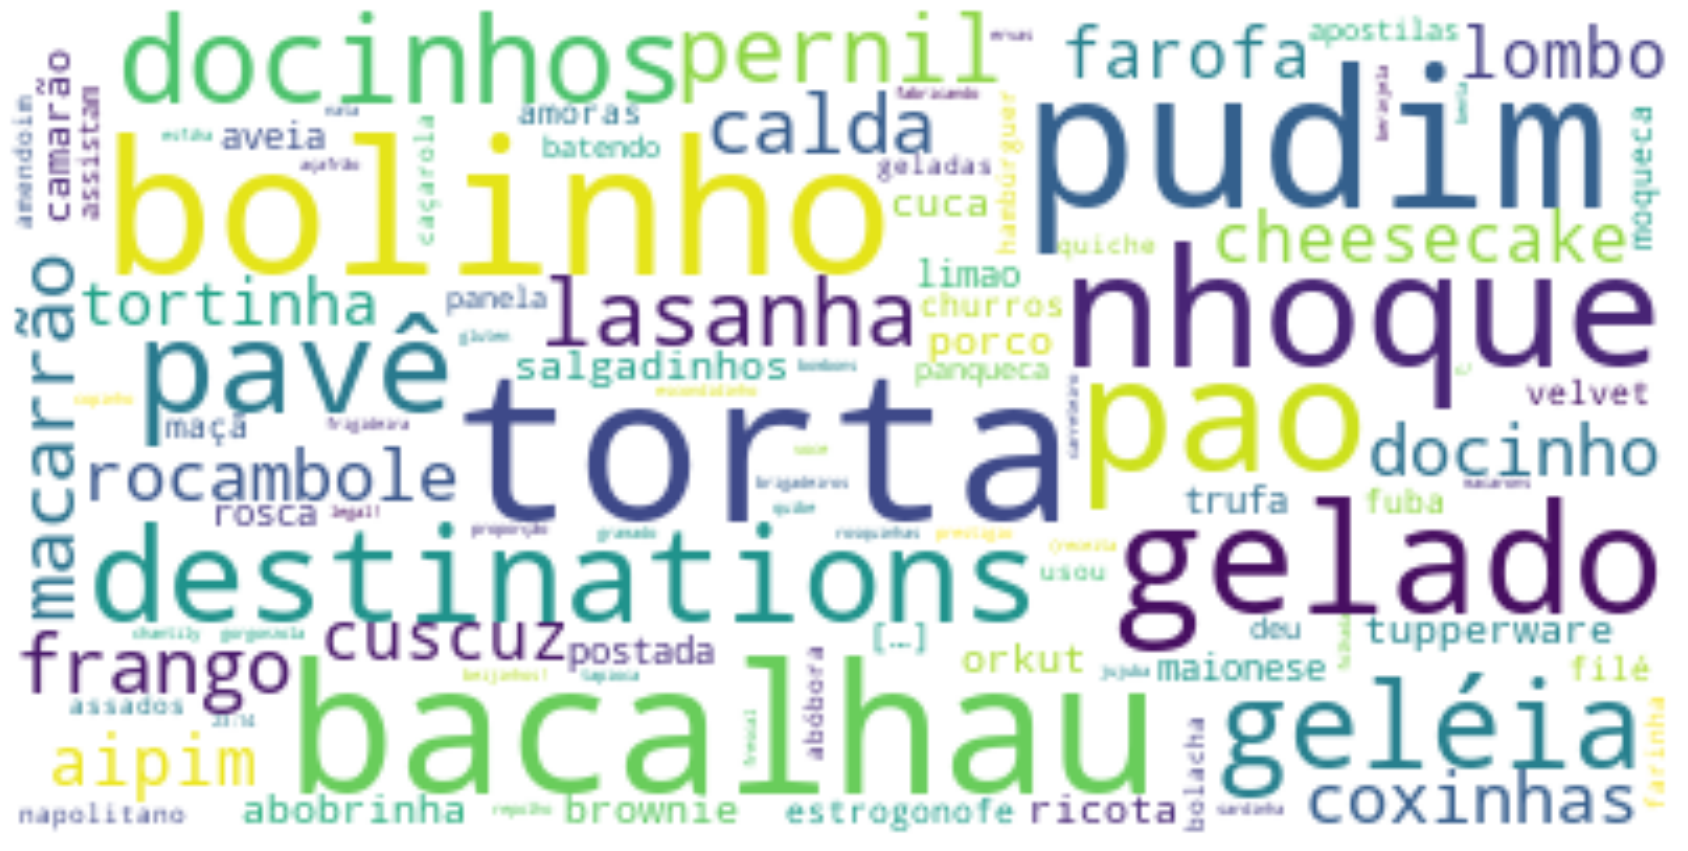

In [54]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(frequencies=dict_freq)
plt.figure()
plt.figure(figsize=(30,40))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("first_review.png")